## Imports & Setup

In [1]:
import sys
import yaml
import shutil
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Add the scripts directory to system path so we can import our modules
# Assumes notebook is in /notebooks and scripts are in /scripts
current_dir = Path.cwd()
sys.path.append(str(current_dir.parent / "scripts"))

# Import our custom robust modules
from project_paths import ROOT_DIR, CONFIG_DIR, DATA_DIR, resolve_path
import model_builder

print(f"✅ Project Root: {ROOT_DIR}")
print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ Devices: {tf.config.list_physical_devices()}")

2025-12-31 12:46:30.552516: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-31 12:46:30.608738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-31 12:46:31.703296: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✅ Project Root: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526
✅ TensorFlow Version: 2.20.0
✅ Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-12-31 12:46:33.349322: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Experiment Manager

In [2]:
def setup_experiment(config):
    """
    Creates a unique run directory and backs up the config.
    Returns: run_dir (Path), log_dir (Path), checkpoint_path (Path)
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = config['project']['run_name']
    
    # Create runs/YYYYMMDD_HHMMSS_run_name
    run_dir = ROOT_DIR / "runs" / f"{timestamp}_{run_name}"
    run_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectories
    log_dir = run_dir / "logs"
    log_dir.mkdir(exist_ok=True)
    
    checkpoint_dir = run_dir / "checkpoints"
    checkpoint_dir.mkdir(exist_ok=True)
    
    # Backup the config file
    with open(run_dir / "config.yaml", 'w') as f:
        yaml.dump(config, f)
        
    print(f"🚀 Experiment initialized at: {run_dir}")
    return run_dir, log_dir, checkpoint_dir

# Load the config
config_path = CONFIG_DIR / "model_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Setup the run
run_dir, log_dir, checkpoint_dir = setup_experiment(config)

🚀 Experiment initialized at: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/20251231_124722_run_01_baseline_cnn


## Data Loading Pipeline

In [3]:
# Resolve the dataset path using our helper (handles absolute/relative)
dataset_path = resolve_path(config['data']['dataset_path'])

img_size = (config['data']['img_height'], config['data']['img_width'])
batch_size = config['data']['batch_size']
color_mode = 'grayscale' if config['data']['channels'] == 1 else 'rgb'

print(f"📂 Loading data from: {dataset_path}")

# 1. Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=config['data']['validation_split'],
    subset="training",
    seed=config['project']['seed'],
    image_size=img_size,
    batch_size=batch_size,
    color_mode=color_mode
)

# 2. Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=config['data']['validation_split'],
    subset="validation",
    seed=config['project']['seed'],
    image_size=img_size,
    batch_size=batch_size,
    color_mode=color_mode
)

# 3. Performance Optimization (The "Secret Sauce" for speed)
# cache() keeps images in memory after the first epoch
# prefetch() prepares the next batch while the GPU/CPU is working
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("✅ Data Pipeline Ready")

📂 Loading data from: /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/data/processed_patches
Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.
✅ Data Pipeline Ready


## Build & Compile the Model

In [4]:
# Build the model dynamically from the config
model = model_builder.build_model_from_config(config)

model.summary()

Model: "run_01_baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0 (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 256, 256, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling2D)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128, 128, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_3 (MaxPooling2D)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_5 (MaxPooling2D)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_6                    │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,697 (428.50 KB)

 Trainable params: 109,505 (427.75 KB)

 Non-trainable params: 192 (768.00 B)

## Callbacks and Training

In [5]:
# Define Callbacks
callbacks = [
    # Stop if validation loss doesn't improve for 'patience' epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['train']['callbacks']['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    # Save the best model to the run folder
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_dir / "best_model.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Log metrics for visualization
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    
    # Save CSV logs for easy plotting later
    tf.keras.callbacks.CSVLogger(str(run_dir / "training_log.csv"))
]

# START TRAINING
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['train']['epochs'],
    callbacks=callbacks
)

# Save the final model just in case
model.save(run_dir / "final_model.keras")
print("🏁 Training Complete!")

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7710 - loss: 0.4742
Epoch 1: val_loss improved from None to 0.76995, saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/20251231_124722_run_01_baseline_cnn/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/20251231_124722_run_01_baseline_cnn/checkpoints/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1602s 2s/step - accuracy: 0.8248 - loss: 0.3939 - val_accuracy: 0.6839 - val_loss: 0.7700
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8927 - loss: 0.2759
Epoch 2: val_loss improved from 0.76995 to 0.29141, saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/20251231_124722_run_01_baseline_cnn/checkpoints/best_model.keras

Epoch 2: finished saving model to /home/nico/workspace/github.com/Nico-Sander/KI-Project-WS2526/runs/20251231_124722_run_01_baseline_cnn/che

## Visualization

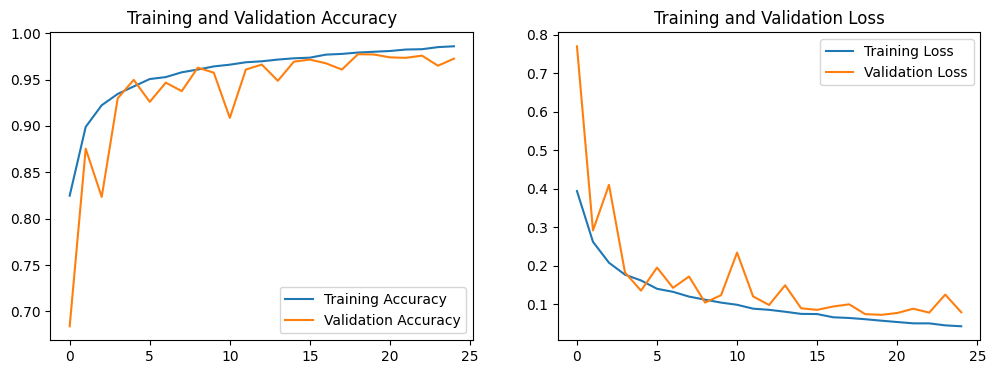

In [6]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()